# compare the OpenPIV Python with PIVLab


In [1]:
%reload_ext watermark
%watermark -v -m -p numpy,openpiv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

numpy  : 1.19.4
openpiv: 0.23.3a0

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 5.4.0-58-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [2]:
from openpiv import windef

import numpy as np
import os
from time import time

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)


In [3]:
settings = windef.Settings()

# 'Data related settings'
# Folder with the images to process
settings.filepath_images = '../data/'
# Folder for the outputs
settings.save_path = '../OpenPIV_results/'
# Root name of the output Folder for Result Files
settings.save_folder_suffix = 'Test_1'
# Format and Image Sequence
settings.frame_pattern_a = 'karman_16Hz_000_A.jpg'
settings.frame_pattern_b = 'karman_16Hz_000_B.jpg'

'Region of interest'
# (50,300,50,300) #Region of interest: (xmin,xmax,ymin,ymax) or 'full' for full image
# settings.ROI = 'full'
settings.ROI = (200,400,500,900)

settings.deformation_method = 'symmetric' # or 'second image'


settings.num_iterations = 4  # select the number of PIV passes

# add the interrogation window size for each pass. 
# For the moment, it should be a power of 2 
settings.windowsizes=(64, 32, 16, 6)
settings.overlap=(32, 16, 8, 3)

# settings.windowsizes = (128, 64, 32, 16, 8) # if longer than n iteration the rest is ignored
# The overlap of the interroagtion window for each pass.
# settings.overlap = (64, 32, 16, 8, 4) # This is 50% overlap


# Has to be a value with base two. In general window size/2 is a good choice.
# methode used for subpixel interpolation: 'gaussian','centroid','parabolic'
settings.subpixel_method = 'gaussian'

# order of the image interpolation for the window deformation
settings.interpolation_order = 1
settings.scaling_factor = 1  # scaling factor pixel/meter
settings.dt = 1  # time between to frames (in seconds)

# 'Signal to noise ratio options (only for the last pass)'
# It is possible to decide if the S/N should be computed (for the last pass) or not
# settings.extract_sig2noise = True  # 'True' or 'False' (only for the last pass)
settings.sig2noise_threshold = 1.05
# method used to calculate the signal to noise ratio 'peak2peak' or 'peak2mean'
settings.sig2noise_method = 'peak2peak'
# select the width of the masked to masked out pixels next to the main peak
settings.sig2noise_mask = 2
settings.sig2noise_validate = True

# If extract_sig2noise==False the values in the signal to noise ratio
# output column are set to NaN

# only effecting the first pass of the interrogation the following passes
# in the multipass will be validated

'Output options'
# Select if you want to save the plotted vectorfield: True or False
settings.save_plot = False
# Choose wether you want to see the vectorfield or not :True or False
settings.show_plot = True
settings.scale_plot = 100  # select a value to scale the quiver plot of the vectorfield
# run the script with the given settings



# 'Processing Parameters'
settings.correlation_method='circular'  # 'circular' or 'linear'
settings.normalized_correlation = False

# 'vector validation options'
# choose if you want to do validation of the first pass: True or False
settings.validation_first_pass = True


settings.filter_method = 'localmean'
# maximum iterations performed to replace the outliers
settings.max_filter_iteration = 10
settings.filter_kernel_size = 1.05  # kernel size for the localmean method

settings.replace_vectors = True

settings.MinMax_U_disp = (-30, 30)
settings.MinMax_V_disp = (-30, 30)

# The second filter is based on the global STD threshold
settings.std_threshold = 5  # threshold of the std validation

# The third filter is the median test (not normalized at the moment)
settings.median_threshold = 3  # threshold of the median validation
# On the last iteration, an additional validation can be done based on the S/N.
settings.median_size = 1  # defines the size of the local median, it'll be 3 x 3


settings.dynamic_masking_method = 'intensity'
settings.dynamic_masking_threshold = 0.1
settings.dynamic_masking_filter_size = 21

# New settings for version 0.23.2c
settings.image_mask = True

# Smoothing after the first pass
settings.smoothn = True #Enables smoothing of the displacemenet field
settings.smoothn_p = 0.5 # This is a smoothing parameter


In [4]:
from openpiv.tools import imread, display_vector_field, save
from openpiv.pyprocess import extended_search_area_piv
from openpiv import pyprocess
from openpiv import preprocess
from openpiv.windef import first_pass, multipass_img_deform
from skimage.measure import points_in_poly
from skimage.util import invert
from openpiv import validation, filters, smoothn, scaling

In [5]:
save_path = os.path.join(
        settings.save_path,
        "Open_PIV_results_"
        + str(settings.windowsizes[settings.num_iterations-1])
        + "_"
        + settings.save_folder_suffix,
    )
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [6]:
# def func(args):
# """A function to process each image pair."""

# this line is REQUIRED for multiprocessing to work
# always use it in your custom function

file_a, file_b, counter = settings.frame_pattern_a, settings.frame_pattern_b, 0


# " read images into numpy arrays"
frame_a = imread(os.path.join(settings.filepath_images, file_a))
frame_b = imread(os.path.join(settings.filepath_images, file_b))

# Miguel: I just had a quick look, and I do not understand the reason
# for this step.
#  I propose to remove it.
# frame_a = (frame_a*1024).astype(np.int32)
# frame_b = (frame_b*1024).astype(np.int32)

# " crop to ROI"
if settings.ROI == "full":
    frame_a = frame_a
    frame_b = frame_b
else:
    frame_a = frame_a[
        settings.ROI[0]:settings.ROI[1],
        settings.ROI[2]:settings.ROI[3]
    ]
    frame_b = frame_b[
        settings.ROI[0]:settings.ROI[1],
        settings.ROI[2]:settings.ROI[3]
    ]

if hasattr(settings, 'invert') and settings.invert is True:
    frame_a = invert(frame_a)
    frame_b = invert(frame_b)

if settings.dynamic_masking_method in ("edge", "intensity"):
    frame_a, mask_a = preprocess.dynamic_masking(
        frame_a,
        method=settings.dynamic_masking_method,
        filter_size=settings.dynamic_masking_filter_size,
        threshold=settings.dynamic_masking_threshold,
    )
    frame_b, mask_b = preprocess.dynamic_masking(
        frame_b,
        method=settings.dynamic_masking_method,
        filter_size=settings.dynamic_masking_filter_size,
        threshold=settings.dynamic_masking_threshold,
    )

In [7]:
# "first pass"
x, y, u, v, s2n = first_pass(
    frame_a,
    frame_b,
    settings.windowsizes[0],
    settings.overlap[0],
    settings.num_iterations,
    correlation_method='linear',
    subpixel_method=settings.subpixel_method,
    do_sig2noise=settings.extract_sig2noise,
    sig2noise_method=settings.sig2noise_method,
    sig2noise_mask=settings.sig2noise_mask,
    normalized_correlation=True,
)

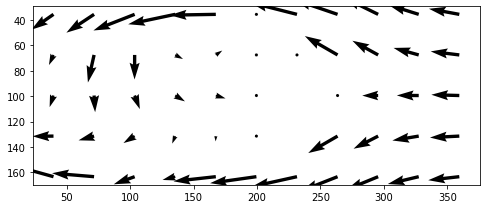

In [8]:
def quick_quiver(x=x,y=y,u=u,v=v):
    fig,ax = plt.subplots()
    ax.quiver(x,y,u,v)
    ax.set_aspect(1)
    ax.invert_yaxis()
    plt.draw()

quick_quiver()

In [9]:
def prepare_mask_on_grid(x,y,mask_coords):
    xymask = points_in_poly(np.c_[y.flatten(), x.flatten()], mask_coords)
    mask = np.zeros_like(x,dtype=bool)
    mask.flat[xymask] = True
    # print("inside prepare mask on grid")
    # plt.figure()
    # plt.pcolor(mask)
    return mask

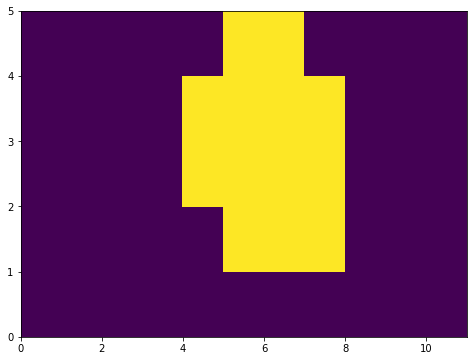

In [10]:
# " Image masking "
if hasattr(settings, 'image_mask') and settings.image_mask:
    image_mask = np.logical_and(mask_a, mask_b)
    mask_coords = preprocess.mask_coordinates(image_mask)
    # mark those points on the grid of PIV inside the mask
    saved_mask = prepare_mask_on_grid(x,y,mask_coords)
    
    u = np.ma.masked_array(u, mask=saved_mask.copy())
    v = np.ma.masked_array(v, mask=saved_mask.copy())
    plt.pcolor(saved_mask)

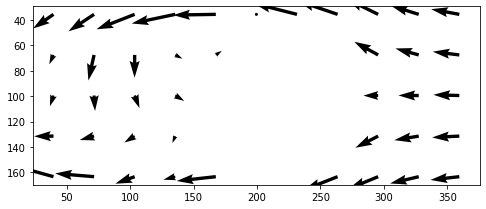

In [11]:
quick_quiver(x,y,u,v)
# plt.figure()
# plt.pcolor(saved_mask)

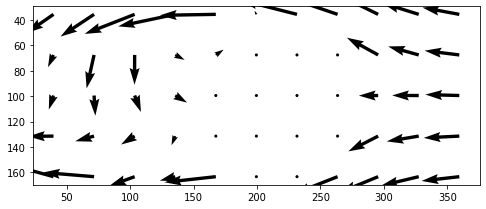

In [12]:
quick_quiver(x,y,u.filled(0.),v.filled(0.))
# plt.figure()
# plt.pcolor(saved_mask)

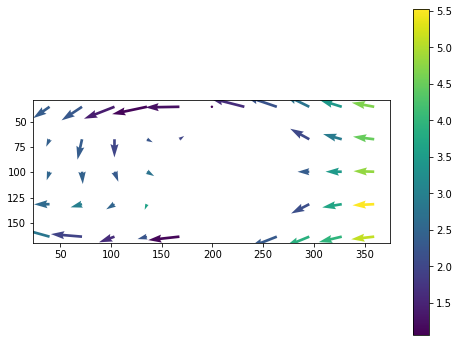

In [13]:
q = plt.quiver(x,y,u,v,s2n)
plt.gca().invert_yaxis()
plt.gca().set_aspect(1)
plt.colorbar(q)

# plt.figure()
# plt.pcolor(saved_mask)

In [14]:
mask = np.full_like(x, False)

if settings.validation_first_pass is True:
    if settings.sig2noise_validate: # use s2n or not
        u, v, mask_s2n = validation.sig2noise_val(
            u, v, s2n,
            threshold=settings.sig2noise_threshold
        )
        # mask += mask_s2n
        
    # quick_quiver(x,y,u,v)
#     plt.figure()
#     plt.pcolor(saved_mask)
    
    u, v, mask_g = validation.global_val(
        u, v, settings.MinMax_U_disp, settings.MinMax_V_disp
    )
    # mask += mask_g
    
    # quick_quiver(x,y,u,v)
#     plt.figure()
#     plt.pcolor(saved_mask)
    
    u, v, mask_s = validation.global_std(
        u, v, std_threshold=settings.std_threshold
    )
    # mask += mask_s
    
    # quick_quiver(x,y,u,v)
#     plt.figure()
#     plt.pcolor(saved_mask)
    
    u, v, mask_m = validation.local_median_val(
        u,
        v,
        u_threshold=settings.median_threshold,
        v_threshold=settings.median_threshold,
        size=settings.median_size,
    )
    # mask += mask_m
    
    # quick_quiver(x,y,u,v)
    
 
    u = np.ma.masked_array(u,mask=saved_mask.copy())
    v = np.ma.masked_array(v,mask=saved_mask.copy())

In [15]:
# quick_quiver(x,y,u,v)

# plt.figure()
# plt.pcolor(saved_mask)

# "filter to replace the values that where marked by the validation"
if settings.num_iterations == 1 and settings.replace_vectors is True:
    # for multi-pass we cannot have holes in the data
    # after the first pass
    u, v = filters.replace_outliers(
        u,
        v,
        method=settings.filter_method,
        max_iter=settings.max_filter_iteration,
        kernel_size=settings.filter_kernel_size,
    )
elif settings.num_iterations > 1: # don't even check if it's true or false
    u, v = filters.replace_outliers(
        u,
        v,
        method=settings.filter_method,
        max_iter=settings.max_filter_iteration,
        kernel_size=settings.filter_kernel_size,
    )
    
u = np.ma.masked_array(u,mask=saved_mask.copy())
v = np.ma.masked_array(v,mask=saved_mask.copy())

# quick_quiver(x,y,u,v)

In [16]:
# plt.pcolor(saved_mask)

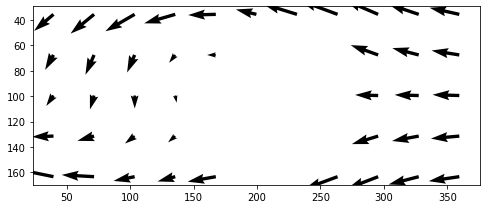

In [17]:
# "adding masks to add the effect of all the validations"
if settings.smoothn is True:
    u, dummy_u1, dummy_u2, dummy_u3 = smoothn.smoothn(
        u, s=settings.smoothn_p
    )
    v, dummy_v1, dummy_v2, dummy_v3 = smoothn.smoothn(
        v, s=settings.smoothn_p
    )
u = np.ma.masked_array(u,mask=saved_mask.copy())
v = np.ma.masked_array(v,mask=saved_mask.copy())
quick_quiver(x,y,u,v)

In [18]:
def create_deformation_field(
        frame, x, y, u, v, interpolation_order=1, kx=3, ky=3):
    """
    Deform an image by window deformation where a new grid is defined based
    on the grid and displacements of the previous pass and pixel values are
    interpolated onto the new grid.

    Parameters
    ----------
    frame : 2d np.ndarray, dtype=np.int32
        an two dimensions array of integers containing grey levels of
        the first frame.

    x : 2d np.ndarray
        a two dimensional array containing the x coordinates of the
        interrogation window centers, in pixels.

    y : 2d np.ndarray
        a two dimensional array containing the y coordinates of the
        interrogation window centers, in pixels.

    u : 2d np.ndarray
        a two dimensional array containing the u velocity component,
        in pixels/seconds.

    v : 2d np.ndarray
        a two dimensional array containing the v velocity component,
        in pixels/seconds.

    interpolation_order: scalar
        the degree of the frame interpolation (deformation) of the mesh

    kx : scalar
         the degree of the interpolation of the B-splines over the x-axis
         of a rectangular mesh

    ky : scalar
         the degree of the interpolation of the B-splines over the
         y-axis of a rectangular mesh

    Returns
    -------
    frame_def:
        a deformed image based on the meshgrid and displacements of the
        previous pass
    """
    # frame = frame.astype(np.float32)
    y1 = y[:, 0]  # extract first coloumn from meshgrid
    #  y1 = y1[::-1]  # flip
    x1 = x[0, :]  # extract first row from meshgrid
    side_x = np.arange(0, np.size(frame[0, :]), 1)  # extract the image grid
    side_y = np.arange(0, np.size(frame[:, 0]), 1)

    # interpolating displacements onto a new meshgrid
    ip = RectBivariateSpline(y1, x1, u, kx=kx, ky=ky)
    ut = ip(side_y, side_x)
    # the way how to use the interpolation functions differs from matlab

    ip2 = RectBivariateSpline(y1, x1, v, kx=kx, ky=ky)
    vt = ip2(side_y, side_x)
    x, y = np.meshgrid(side_x, side_y)
    return x, y, ut, vt

In [19]:
from openpiv.pyprocess import get_coordinates, get_field_shape
from scipy.interpolate import RectBivariateSpline
# from openpiv.windef import create_deformation_field
import scipy.ndimage as scn
        
def multipass_img_deform(
    frame_a,
    frame_b,
    iteration,
    x_old,
    y_old,
    u_old,
    v_old,
    mask_coords=[],
    settings=windef.Settings(),
):
    """
    Multi pass of the PIV evaluation.

    This function does the PIV evaluation of the second and other passes.
    It returns the coordinates of the interrogation window centres,
    the displacement u, v for each interrogation window as well as
    the signal to noise ratio array (which is full of NaNs if opted out)


    Parameters
    ----------
    frame_a : 2d np.ndarray
        the first image

    frame_b : 2d np.ndarray
        the second image

    window_size : tuple of ints
         the size of the interrogation window

    overlap : tuple of ints
        the overlap of the interrogation window, e.g. window_size/2

    x_old : 2d np.ndarray
        the x coordinates of the vector field of the previous pass

    y_old : 2d np.ndarray
        the y coordinates of the vector field of the previous pass

    u_old : 2d np.ndarray
        the u displacement of the vector field of the previous pass
        in case of the image mask - u_old and v_old are MaskedArrays

    v_old : 2d np.ndarray
        the v displacement of the vector field of the previous pass

    subpixel_method: string
        the method used for the subpixel interpolation.
        one of the following methods to estimate subpixel location of the peak:
        'centroid' [replaces default if correlation map is negative],
        'gaussian' [default if correlation map is positive],
        'parabolic'

    interpolation_order : int
        the order of the spline interpolation used for the image deformation

    mask_coords : list of x,y coordinates (pixels) of the image mask,
        default is an empty list

    Returns
    -------
    x : 2d np.array
        array containg the x coordinates of the interrogation window centres

    y : 2d np.array
        array containg the y coordinates of the interrogation window centres

    u : 2d np.array
        array containing the horizontal displacement for every interrogation
        window [pixels]

    u : 2d np.array
        array containing the vertical displacement for every interrogation
        window it returns values in [pixels]

    s2n : 2D np.array of signal to noise ratio values

    """

    y_old = y_old[:, 0]
    x_old = x_old[0, :]

    # calculate the y and y coordinates of the interrogation window centres.
    # The interpolation function dont like meshgrids as input. Hence, the
    # edges must be extracted to provide the sufficient input. x_old and y_old
    # are the coordinates of the old grid. x_int and y_int are the coordinates
    # of the new grid

    x, y = get_coordinates(np.shape(frame_a),
                           settings.windowsizes[iteration],
                           settings.overlap[iteration])

#     # reapply the image mask to the new coordinates
#     if len(mask_coords) > 1:  # not an empty list means there is a mask
#         image_mask = prepare_mask_on_grid(x,y,mask_coords)

    y_int = y[:, 0]
    x_int = x[0, :]


    # interpolating the displacements from the old grid onto the new grid
    # y befor x because of numpy works row major
    ip = RectBivariateSpline(y_old, x_old, u_old, kx=2, ky=2)
    u_pre = ip(y_int, x_int)

    ip2 = RectBivariateSpline(y_old, x_old, v_old, kx=2, ky=2)
    v_pre = ip2(y_int, x_int)

#     if len(mask_coords) > 1:
#         u_pre = np.ma.masked_array(u_pre, mask=image_mask)
#         v_pre = np.ma.masked_array(v_pre, mask=image_mask)

    # if settings.show_plot:
    plt.figure()
    plt.quiver(x_old, y_old, u_old, v_old,color='b')
    plt.quiver(x_int, y_int, u_pre, v_pre,color='r',lw=2)
    plt.gca().invert_yaxis()
    plt.title('inside deform')
    plt.gca().set_aspect(1.)

    # @TKauefer added another method to the windowdeformation, 'symmetric'
    # splits the onto both frames, takes more effort due to additional
    # interpolation however should deliver better results

    # old_frame_a = frame_a.copy()
    # old_frame_b = frame_b.copy()

    if settings.deformation_method == "symmetric":
        # this one is doing the image deformation (see above)
        x_new, y_new, ut, vt = create_deformation_field(
            frame_a, x, y, u_pre, v_pre)
        frame_a = scn.map_coordinates(
            frame_a, ((y_new - vt / 2, x_new - ut / 2)),
            order=settings.interpolation_order, mode='nearest')
        frame_b = scn.map_coordinates(
            frame_b, ((y_new + vt / 2, x_new + ut / 2)),
            order=settings.interpolation_order, mode='nearest')
    elif settings.deformation_method == "second image":
        frame_b = deform_windows(
            frame_b, x, y, u_pre, v_pre,
            interpolation_order=settings.interpolation_order)
    else:
        raise Exception("Deformation method is not valid.")

    # if settings.show_plot:
    #     plt.figure()
    #     plt.imshow(frame_a-old_frame_a)
    #     plt.figure()
    #     plt.imshow(frame_b-old_frame_b)

    # if do_sig2noise is True 
    #     sig2noise_method = sig2noise_method
    # else:
    #     sig2noise_method = None

    # so we use here default circular not normalized correlation:
    u, v, s2n = extended_search_area_piv(
        frame_a,
        frame_b,
        window_size=settings.windowsizes[iteration],
        overlap=settings.overlap[iteration],
        width=settings.sig2noise_mask,
        subpixel_method=settings.subpixel_method,
        sig2noise_method=settings.sig2noise_method,  # if it's None, it's not used
        correlation_method=settings.correlation_method,
        normalized_correlation=settings.normalized_correlation,
    )
    
    plt.figure()
    q = plt.quiver(x,y,u,v,s2n)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect(1)
    plt.colorbar(q)
    
    shapes = np.array(get_field_shape(frame_a.shape,
                                      settings.windowsizes[iteration],
                                      settings.overlap[iteration]))
    u = u.reshape(shapes)
    v = v.reshape(shapes)
    s2n = s2n.reshape(shapes)
    
    
    # Before we add this part to the previous, we have to clean it up
    # that was my original mistake probably when I moved it out of the 
    # loop, so we added a lot of noise 

    image_mask = prepare_mask_on_grid(x,y,mask_coords)

    quick_quiver(x,y,u,v)

    mask = np.full_like(x, False, dtype=bool)
    # validation every step
    u, v, mask_g = validation.global_val(
        u, v, settings.MinMax_U_disp, settings.MinMax_V_disp
    )


    quick_quiver(x,y,u,v)

    u, v, mask_s = validation.global_std(
        u, v, std_threshold=settings.std_threshold
    )

    quick_quiver(x,y,u,v)

    u, v, mask_m = validation.local_median_val(
        u,
        v,
        u_threshold=settings.median_threshold,
        v_threshold=settings.median_threshold,
        size=settings.median_size,
    )
    mask = mask + mask_s + mask_m + mask_g

    quick_quiver(x,y,u,v)

    if settings.sig2noise_method is not None:
        u, v, mask_s2n = validation.sig2noise_val(
            u, v, s2n, threshold=settings.sig2noise_threshold
        )
        mask = mask + mask_s2n

    # we have to replace outliers
    u, v = filters.replace_outliers(
        u,
        v,
        method=settings.filter_method,
        max_iter=settings.max_filter_iteration,
        kernel_size=settings.filter_kernel_size,
    )

    u = np.ma.masked_array(u, mask=image_mask)
    v = np.ma.masked_array(v, mask=image_mask)
    quick_quiver(x,y,u,v)

    # plt.figure()
    # plt.pcolor(image_mask)

    # If the smoothing is active, we do it at each pass
    # but not the last one
    # print(i,settings.num_iterations-1)
    if settings.smoothn is True and iteration < settings.num_iterations-1:
        # print('smoothing')
        u, dummy_u1, dummy_u2, dummy_u3 = smoothn.smoothn(
            u, s=settings.smoothn_p
        )
        v, dummy_v1, dummy_v2, dummy_v3 = smoothn.smoothn(
            v, s=settings.smoothn_p
        )

    u = np.ma.masked_array(u, mask=image_mask)
    v = np.ma.masked_array(v, mask=image_mask)
    
    quick_quiver(x,y,u,v)

    # plt.figure()
    # plt.pcolor(image_mask)


    plt.figure()
    plt.quiver(x_int, y_int, u, v,color='r')
    plt.quiver(x_int, y_int, u_pre, v_pre,color='b')
    plt.gca().invert_yaxis()
    
    plt.figure()
    plt.hist(u_pre.flatten(),alpha=0.5,color='b')
    plt.hist(u.flatten(),alpha=0.5,color='r')

    # adding the recent displacment on to the displacment of the previous pass
    # u += u_pre
    # v -= v_pre
    u = u_pre + u
    v = v_pre + v
    
    u = np.ma.masked_array(u, mask=image_mask)
    v = np.ma.masked_array(v, mask=image_mask)
    
    plt.figure()
    q = plt.quiver(x,y,u,v,s2n)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect(1)
    plt.colorbar(q)

#     # reapply image mask just to be sure
#     if len(mask_coords) > 1:
#         u = np.ma.masked_array(u, mask=image_mask)
#         v = np.ma.masked_array(v, mask=image_mask)

    # if settings.show_plot:
    #     plt.figure()
    #     plt.quiver(x_int, y_int, u, v,color='r')
    #     plt.quiver(x_int, y_int, u_pre, v_pre,color='b')
    #     plt.gca().invert_yaxis()
    #     plt.gca().set_aspect(1)

    return x, y, u, v, s2n

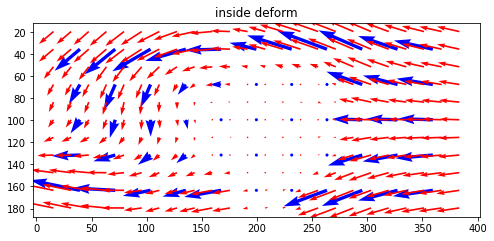

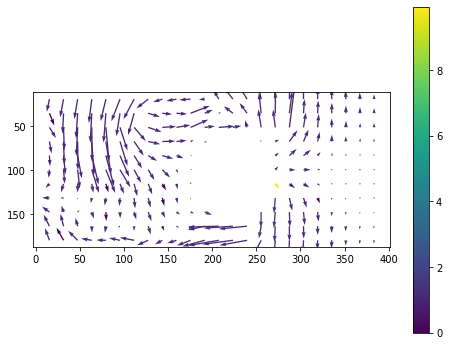

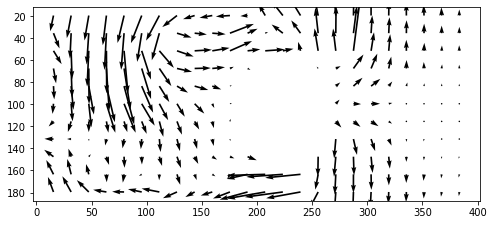

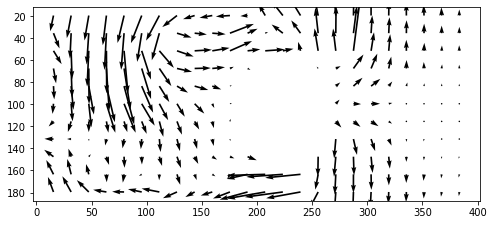

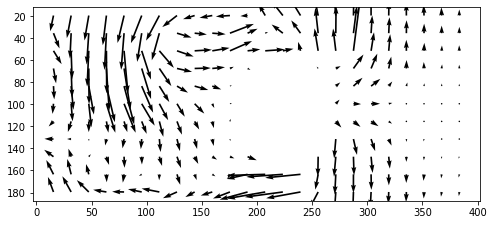

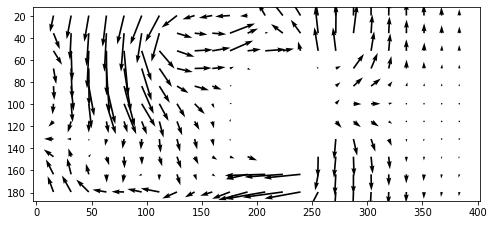

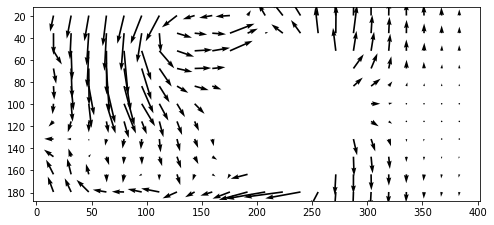

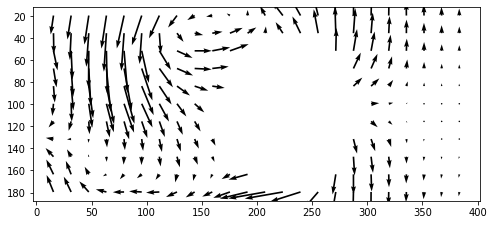

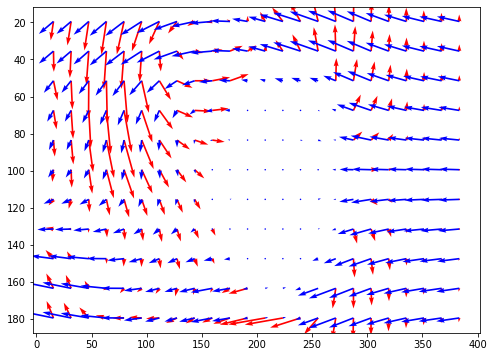

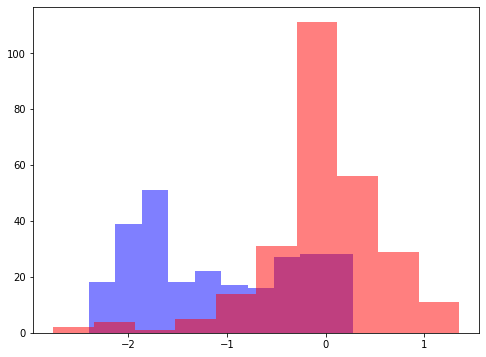

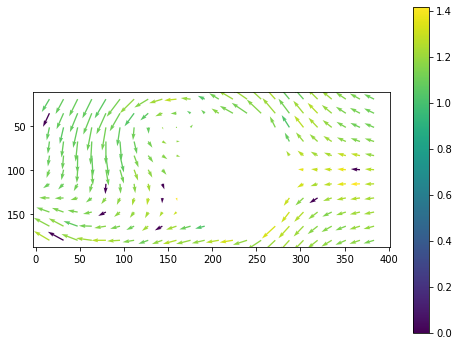

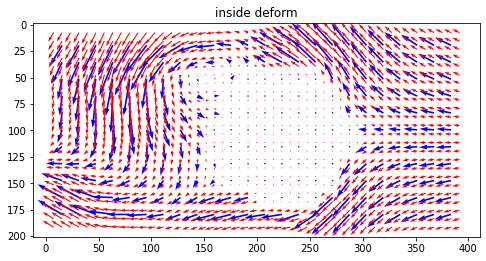

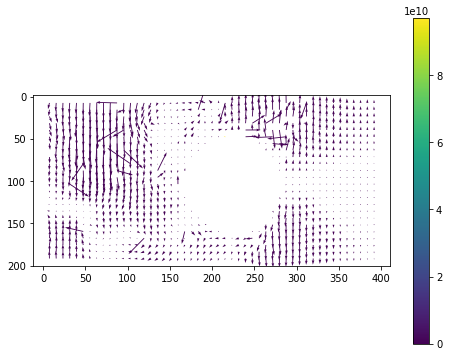

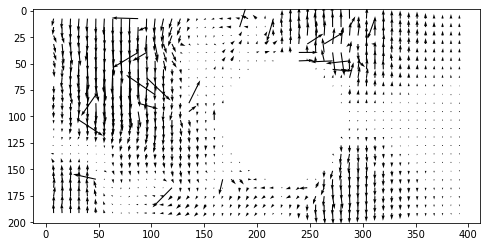

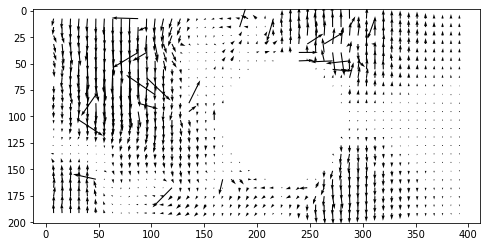

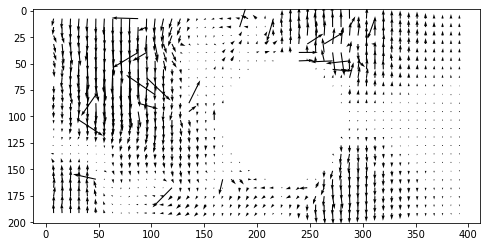

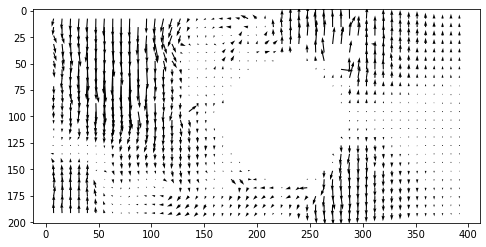

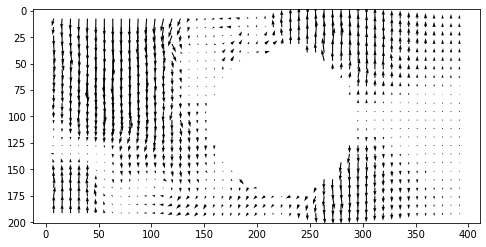

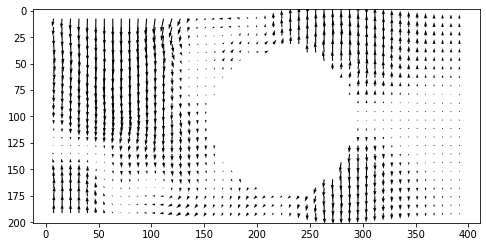

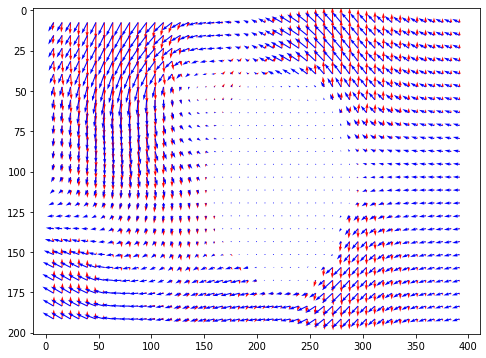

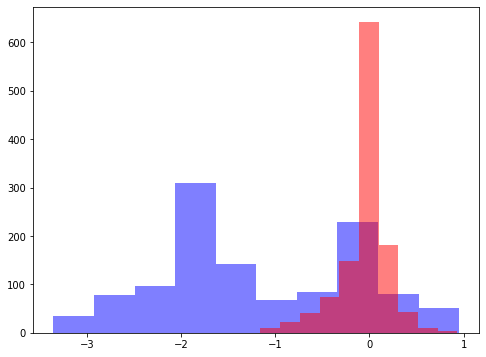

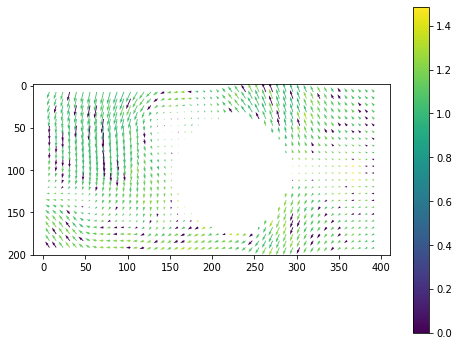

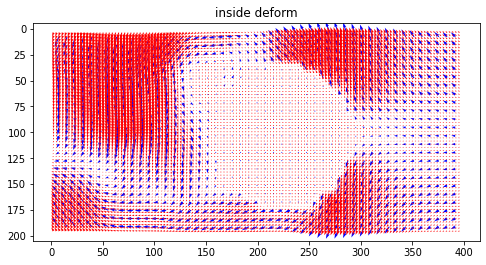

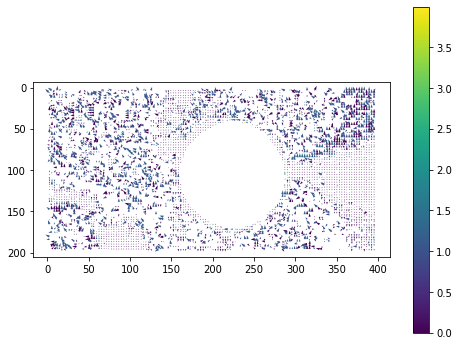

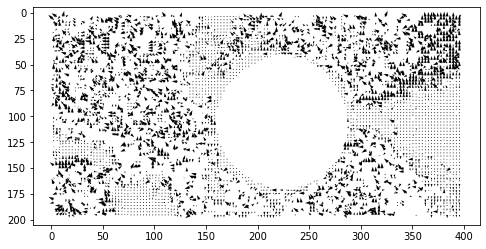

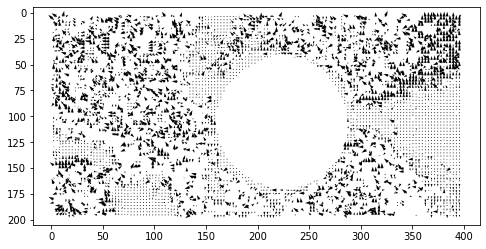

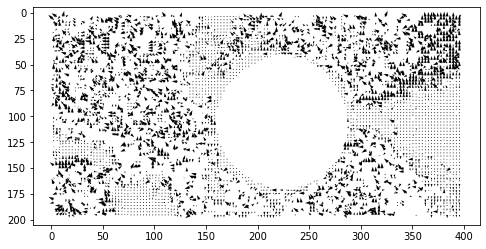

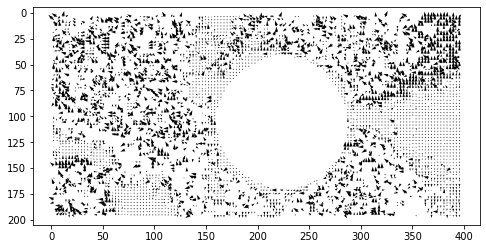

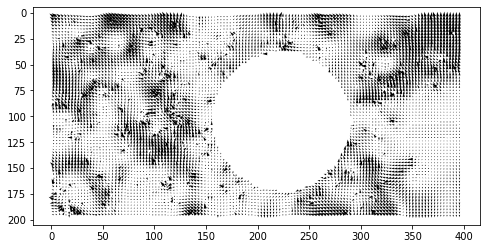

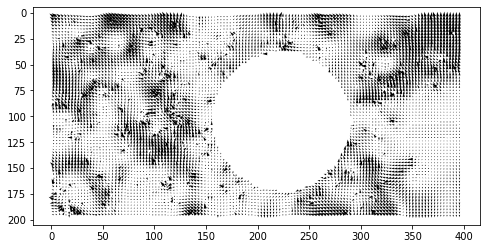

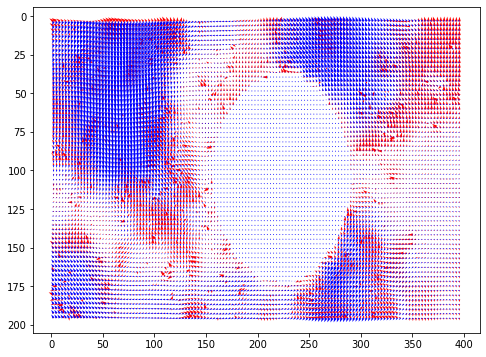

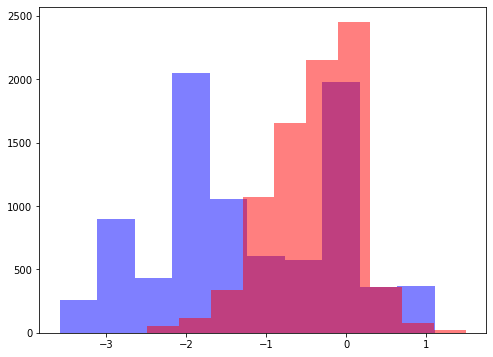

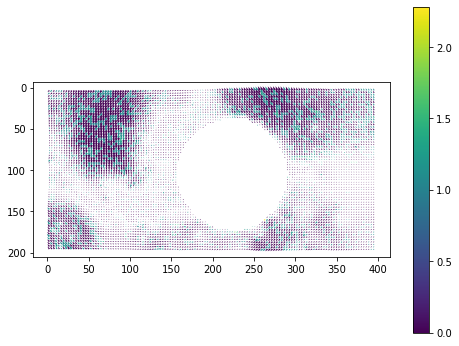

In [20]:
# %pdb
""" Multi pass """

for iteration in range(1, settings.num_iterations):
    # i = 1
    # print(i)
    # print(settings.windowsizes[i])

    x, y, u, v, s2n = multipass_img_deform(
        frame_a,
        frame_b,
        iteration,
        x,
        y,
        u.filled(0.),
        v.filled(0.),
        mask_coords=mask_coords,
        settings = settings,
    )

In [21]:
# "pixel/frame->pixel/sec"
u = u / settings.dt
v = v / settings.dt

image_mask = prepare_mask_on_grid(x,y,mask_coords)

# "scales the results pixel-> meter"
x, y, u, v = scaling.uniform(x, y, u, v,
                             scaling_factor=settings.scaling_factor)

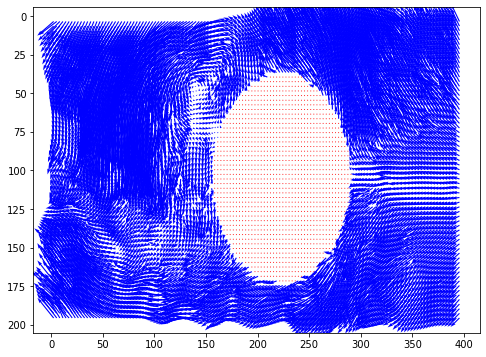

Image Pair 1


In [22]:
# "save to a file"
save(
    x,
    y,
    u.filled(0.),
    v.filled(0.),
    s2n,
    image_mask,
    os.path.join(save_path, "field_A%03d.txt" % counter),
    delimiter="\t",
)

# "some other stuff that one might want to use"
if settings.show_plot is True or settings.save_plot is True:
    plt.close("all")
    plt.ioff()
    Name = os.path.join(save_path, "Image_A%03d.png" % counter)
    fig, _ = display_vector_field(
        os.path.join(save_path, "field_A%03d.txt" % counter),
        scale=settings.scale_plot,
    )
    if settings.save_plot is True:
        fig.savefig(Name)
    if settings.show_plot is True:
        plt.show()

print("Image Pair " + str(counter + 1))

In [23]:
from pivpy import pivpy, io, graphics
import xarray as xr

In [24]:
import glob
file_list = sorted(glob.glob('../OpenPIV_results/Open_PIV_results_6_Test_1/*.txt'))

data = []
frame = 0
for f in file_list:
    data.append(io.load_txt(f,frame=frame))
    frame += 1
    
data = xr.concat(data,dim='t')
data.attrs['units']= ['pix','pix','pix/dt','pix/dt']

In [25]:
data.piv.vorticity()

<xarray.Dataset>
Dimensions:  (t: 1, x: 132, y: 65)
Coordinates:
  * t        (t) int64 0
  * x        (x) float64 2.5 5.5 8.5 11.5 14.5 ... 383.5 386.5 389.5 392.5 395.5
  * y        (y) float64 3.5 6.5 9.5 12.5 15.5 ... 183.5 186.5 189.5 192.5 195.5
Data variables:
    u        (x, y, t) float64 -3.657 -3.506 -3.194 ... -2.001 -2.001 -2.001
    v        (x, y, t) float64 -3.188 -3.274 -3.476 ... -2.029 -2.01 -2.01
    chc      (x, y, t) float64 0.0 1.022 0.0 0.0 0.0 ... 0.0 1.04 1.008 1.012
    w        (x, y, t) float64 0.08887 -0.09127 -0.1112 ... 0.00905 0.002 -0.001
Attributes:
    variables:  None
    units:      ['pix', 'pix', 'pix/dt', 'pix/dt', '1/dt']
    dt:         None
    files:      ../OpenPIV_results/Open_PIV_results_6_Test_1/field_A000.txt

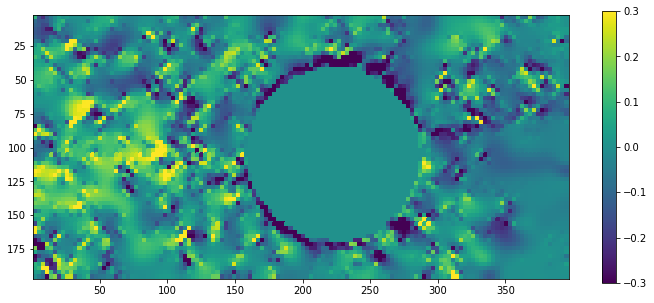

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(12,5))
# for ax in axs:
s = ax.pcolor(data.x,data.y,data.w.T.isel(t=0), shading='nearest', vmin=-.3, vmax=.3)
ax.invert_yaxis()
ax.set_aspect(1)
fig.colorbar(s, ax=ax,)
plt.show()